## Test Notebook for modules in *spectral.py* and *feature.py*

In [1]:
%matplotlib inline
import os,sys, math
import numpy as np
import librosa
import pyspch.utils as U
import pyspch.sp as Sps
import pyspch.audio as Spa
import pyspch.io as Spio
import pyspch.display as Spd
#from pyspch.utils.constants import *

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

### Load a Data File and segmentation if available

In [2]:
dir = 'https://homes.esat.kuleuven.be/~spchlab/data/'
name = 'misc/bad_bead_booed'
#name ='misc/b_8k'
name = 'misc/friendly'
#name = 'timit/si1027'
#
wavfname = os.path.join(dir,name+".wav")
wavdata, sr = Spa.load(wavfname)
if sr > 16000:
    wavdata, sr = Spa.load(wavfname,sample_rate=16000) 

# get segmentations and convert TIMIT segmentations from sample indices to time, plus map from the TIMIT61 alphabet to CMU
dsegt = 1.
xlat = None
if name.split('/')[0] == 'timit':
    dsegt = 1./16000.
    xlat = 'map61_cmu'
    
# try to find a segmentation, grapheme or phoneme or word
seg = Spio.timit.read_seg_file(dir+name+ ".gra",dt=dsegt,fmt='float32')
if seg is None: seg = Spio.read_seg_file(dir+name+ ".phn",dt=dsegt,fmt='float32',xlat=xlat)
if seg is None: seg = Spio.read_seg_file(dir+name+ ".wrd",dt=dsegt,fmt='float32')

### 1. Fourier Spectrogram

Noteable differences with librosa:
- frame positioning is same as Kaldi/SPRAAK
    + frame i is positioned \[ i\*n_shift, (i+1)\*n_shift \] 
    + frame i is symmetrically extended to accomodate n_length and ultimately n_fft
    + padding via mirroring at the signal edges
    + n_frames = n_samples // n_shift
- all spectral routines can use the 'mode' argument to specify the input/output mode of the spectral representations; options are 'power','magnitude' and 'dB'
- 'S' denotes the power spectrum, 'spg' the log spectrum 

Multiple examples with various segmentations in spectrogram_tst.ipynb

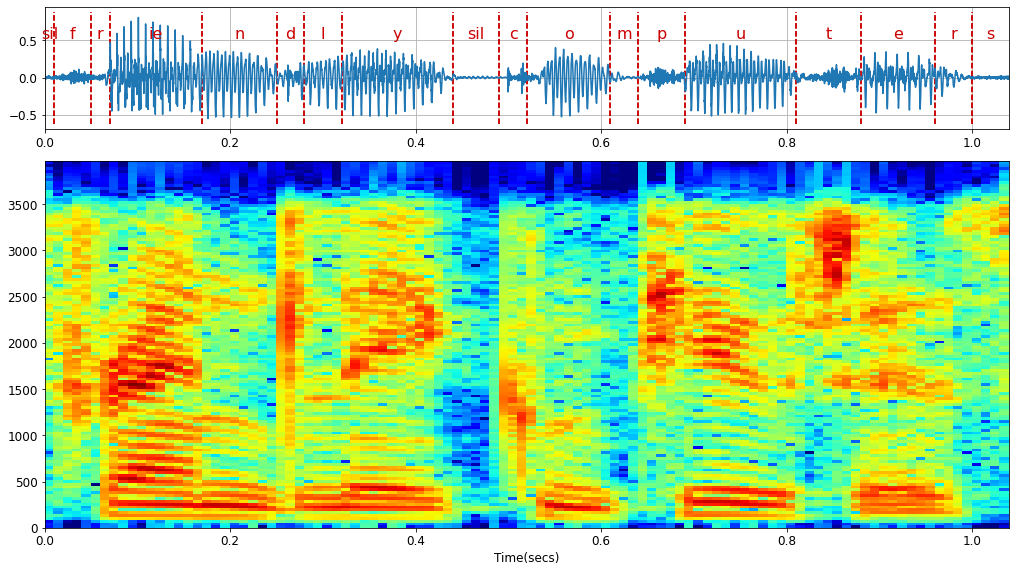

In [3]:
# compute a spectrogram as starting point for further analysis
shift=0.01
length=0.030
n_shift = int(shift*sr)
n_length = int(length*sr)
n_fft = 2**math.ceil(math.log2(n_length))
spg = Sps.spectrogram(wavdata,sample_rate=sr,f_shift=shift,n_mels=None,mode='dB')
(n_param,n_frames)=spg.shape
d_freq = sr/(2.*(n_param-1))
fig = Spd.PlotSpg(wavdata=wavdata,spgdata=spg,segwav=seg,sample_rate=sr,figsize=(14,8))
fig

### 2. Mel Spectrogram

- Don't forget to pass sample rate as argument in spg2mel !! to know how to fit the f2mel mapping
- You can set fmin and fmax for the range of the mel filterbank.  fmin defaults to 40Hz, fmax to 0.45\*sr; this is more tight than in librosa (full range) or even slightly more than Kaldi 

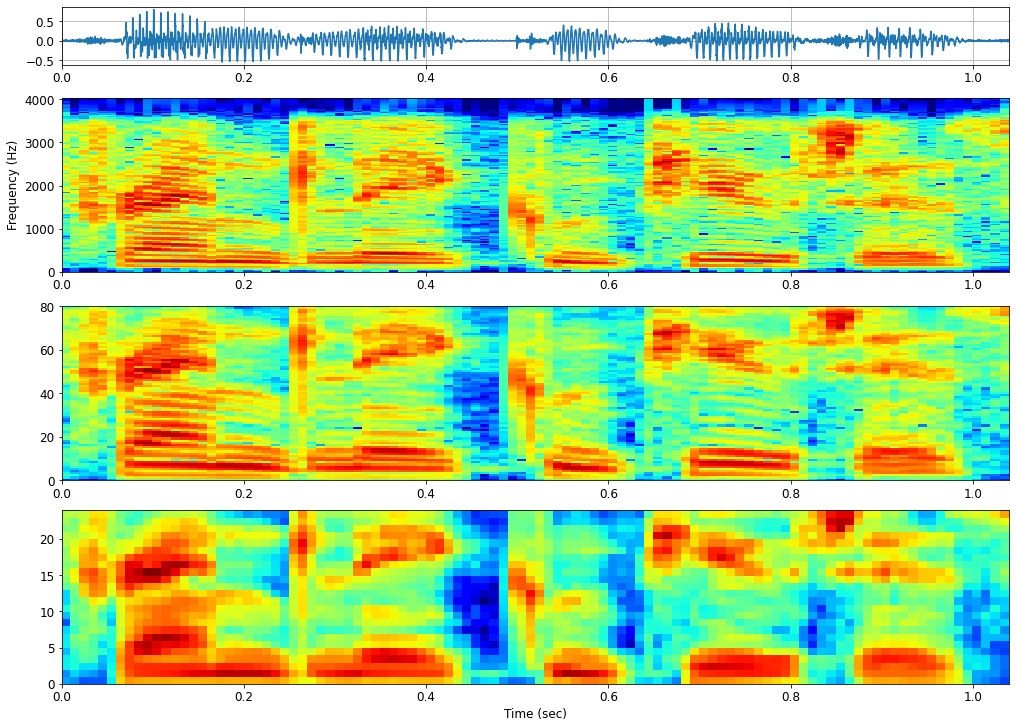

In [4]:
spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None,mode='dB')
spg_mel80 = Sps.spg2mel(spg,sample_rate=sr,n_mels=80,mode='dB')
spg_mel24 = Sps.spg2mel(spg,sample_rate=sr,n_mels=24,mode='dB')
Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg,img_ftrs=[spg_mel80,spg_mel24],sample_rate=sr,figsize=(14,10))

### 3. Cepstrum, Spectral Envelope & Residue

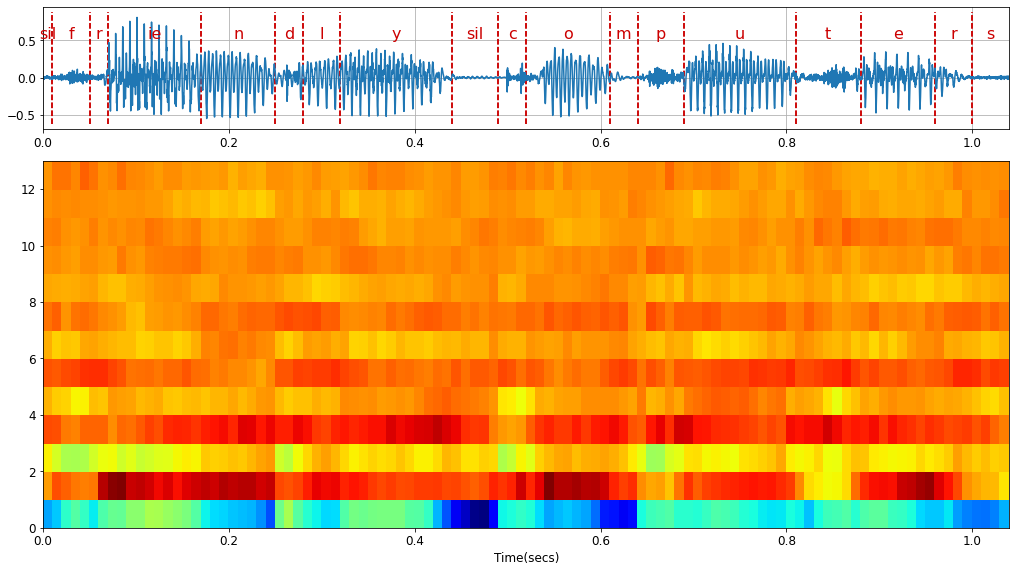

In [5]:
cep = Sps.cepstrum(S=spg,n_cep=13,mode='dB')
Spd.PlotSpg(wavdata=wavdata,spgdata=cep,segwav=seg,dy=1,sample_rate=sr,figsize=(14,8))

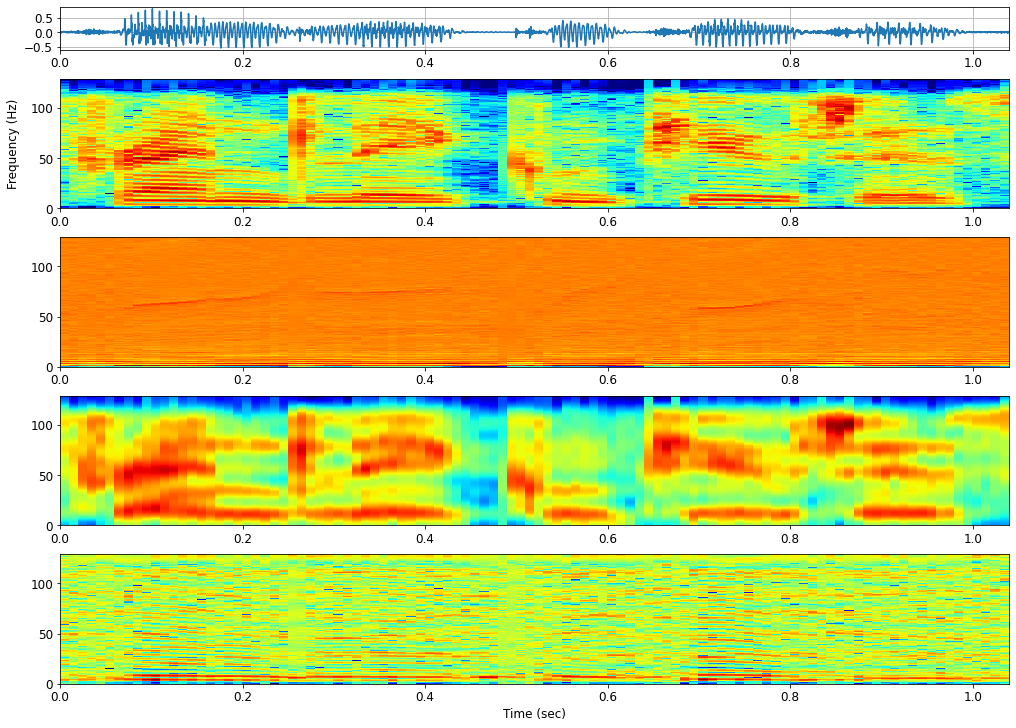

In [6]:
cep = Sps.cepstrum(S=spg,mode='dB')
spec_env, spec_res = Sps.cep_lifter(cep,n_lifter=13,n_spec=129)
Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg, img_ftrs=[cep,spec_env,spec_res],dy=1,sample_rate=sr,figsize=(14,10))

### 4. Mel Cepstrum

The number of mel channels is not very important if ultimately reducing to a low number of MFCC coefficients.   See the difference between 24 and 80 channel mel filterbanks, for 13 MFCC coefficients

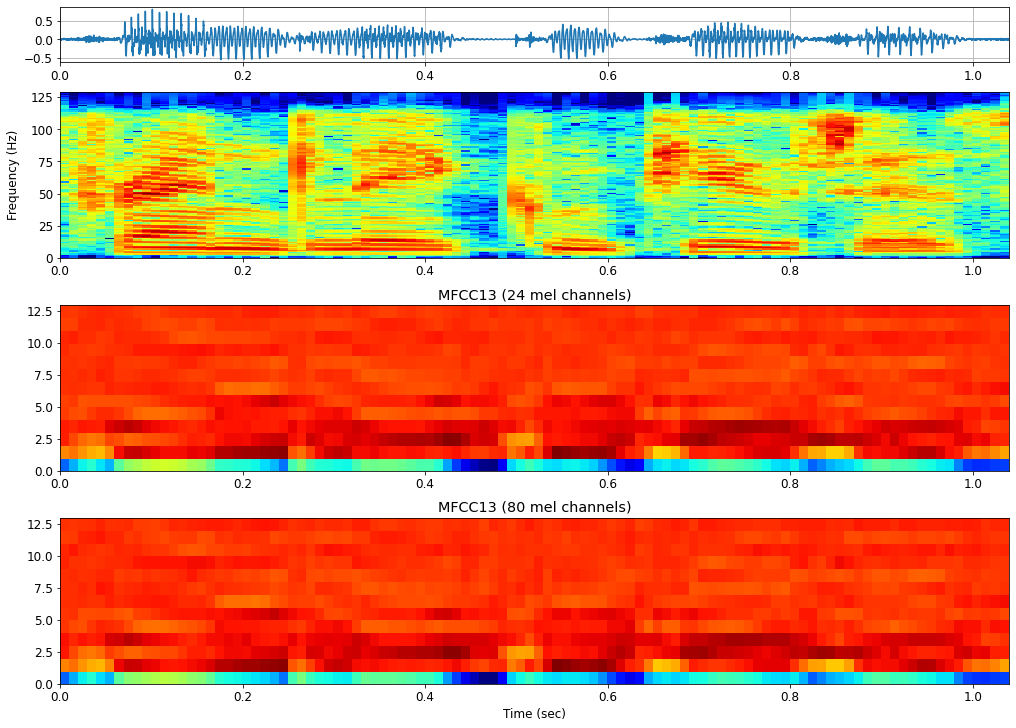

In [7]:
#spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None,mode='dB')
#spg_mel80 = Sps.spg2mel(spg,sample_rate=sr,n_mels=80,mode='dB')
#spg_mel24 = Sps.spg2mel(spg,sample_rate=sr,n_mels=24,mode='dB')
mfcc13 = Sps.cepstrum(S=spg_mel24,n_cep=13,mode='dB')
# alt: mfcc13 = Sps.melcepstrum(S=spg,sample_rate=sr,n_mels=24,n_cep=13)
mfcc13_80 = Sps.cepstrum(S=spg_mel80,n_cep=13,mode='dB')

fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg, img_ftrs=[mfcc13,mfcc13_80],dy=1,sample_rate=sr,figsize=(14,10))
fig.axes[2].set_title("MFCC13 (24 mel channels)")
fig.axes[3].set_title("MFCC13 (80 mel channels)")
display(fig)

### 5. MFCC-39
add delta's and ddelta's, and finally mean_norm

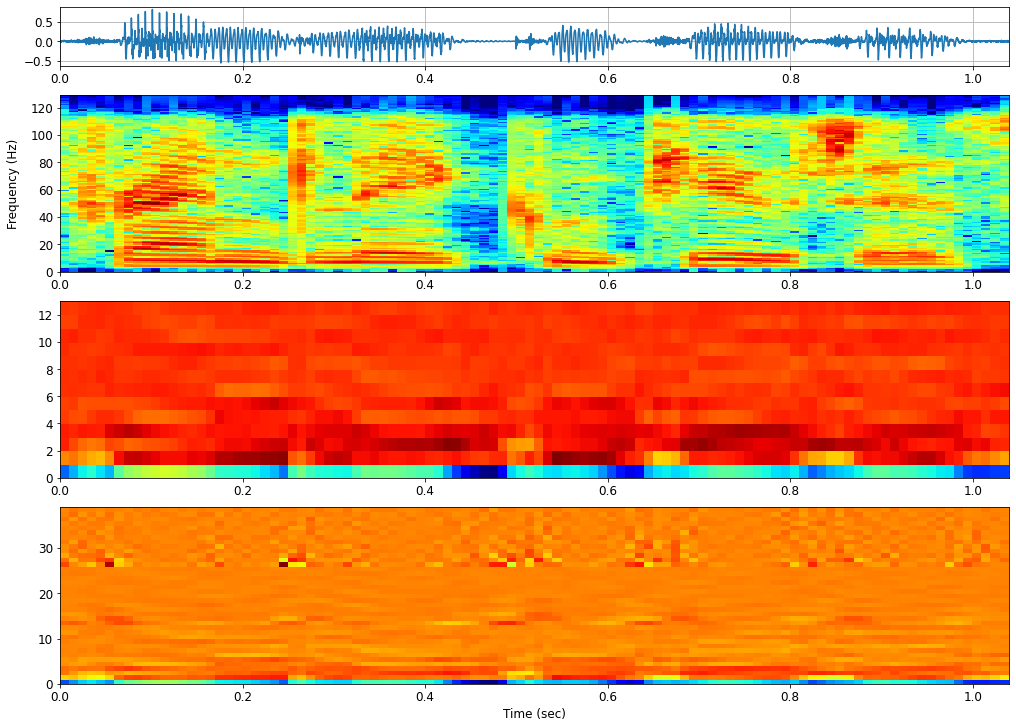

In [8]:
mfcc13 = Sps.melcepstrum(S=spg,sample_rate=sr,n_mels=24,n_cep=13)
ftrs = Sps.deltas(mfcc13,type="delta_delta2",Augment=True)
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg, img_ftrs=[mfcc13,ftrs],dy=1,sample_rate=sr,figsize=(14,10))
display(fig)

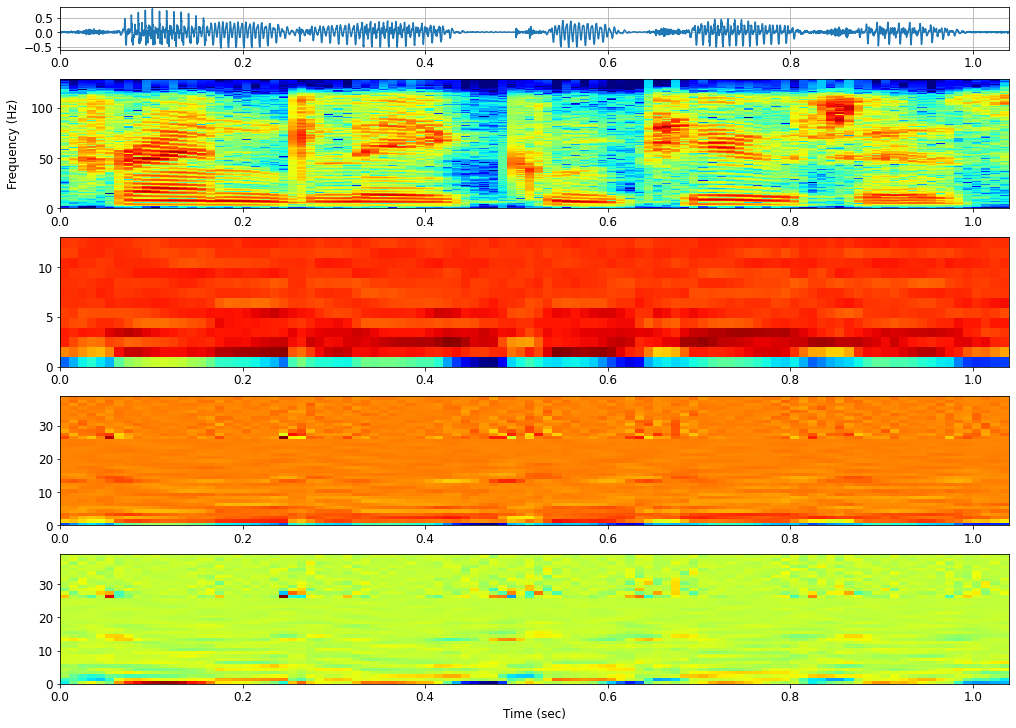

In [9]:
ftrs_n = Sps.mean_norm(ftrs)
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg, img_ftrs=[mfcc13,ftrs,ftrs_n],dy=1,sample_rate=sr,figsize=(14,10))
display(fig)

### 6. Feature Splicing

In [11]:
X = [ [ 0,1,2] , [3,4,5] ]
X = np.array(X)
N=2
X, Sps.pad_frames(X,N=2), Sps.splice_frames(X,N=2,stride=2)

(array([[0, 1, 2],
        [3, 4, 5]]),
 array([[0, 0, 0, 1, 2, 2, 2],
        [3, 3, 3, 4, 5, 5, 5]]),
 array([[0, 0, 0],
        [3, 3, 3],
        [0, 0, 0],
        [3, 3, 3],
        [0, 1, 2],
        [3, 4, 5],
        [2, 2, 2],
        [5, 5, 5],
        [2, 2, 2],
        [5, 5, 5]]))

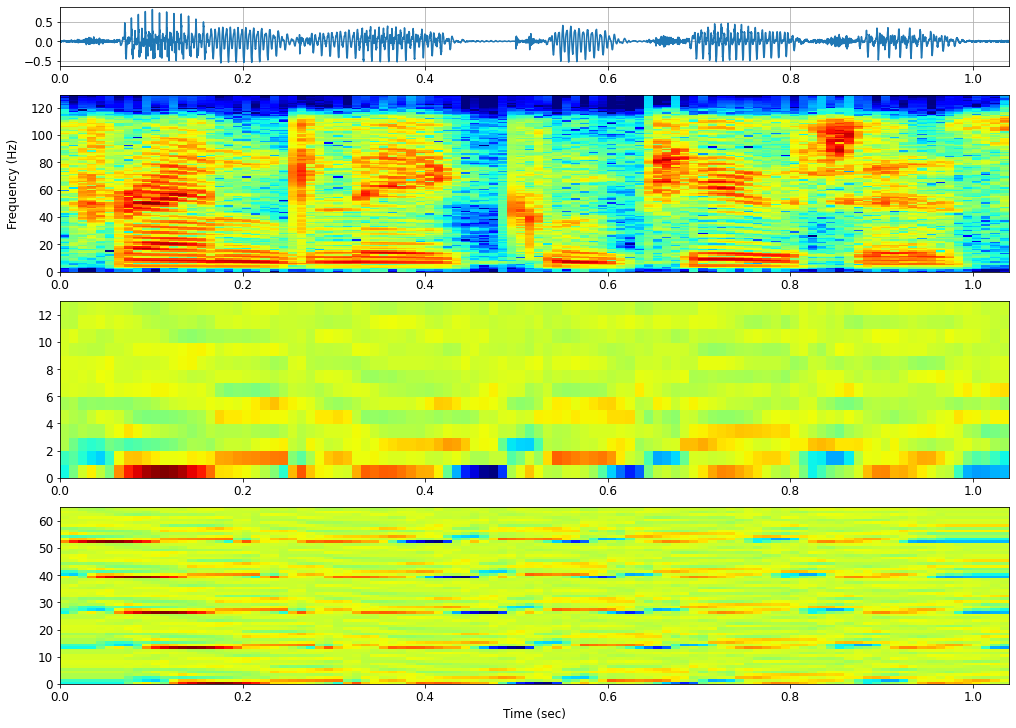

In [15]:
mfcc_n = Sps.mean_norm(mfcc13)
ftrs = Sps.splice_frames(mfcc_n,N=2,stride=3)
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg, img_ftrs=[mfcc_n,ftrs],dy=1,sample_rate=sr,figsize=(14,10))
display(fig)

## 7. Standard Feature Processing
a. 39D MFCC's after mean norm  (perceptive field = 7 frames)
b. 11*80 mel spectra (stride 2, perceptive field = 21 frames)   mean norm ?

In [22]:
spg = Sps.spectrogram(wavdata,sample_rate=sr,f_shift=shift)
mfcc13 = Sps.melcepstrum(S=spg,sample_rate=sr,n_mels=24,n_cep=13)
mfcc39 = Sps.deltas(Sps.mean_norm(mfcc13),type="delta_delta2",Augment=True)
mfcc39.shape

(39, 104)

In [23]:
mel80 = Sps.spg2mel(spg,sample_rate=sr,n_mels=80)
mel80s = Sps.splice_frames(mel80,N=5,stride=2)
mel80s.shape

(880, 104)

#### Comparing with the librosa implementation, either
- directly from waveform
- just from the mel spectrum

In [ ]:
pad = (n_fft-n_shift)//2
y= Sps.preemp_pad(wavdata,pad=88,preemp=.97)
mfcc_from_mel = librosa.feature.mfcc(S=spg_mel24, n_mfcc=13, dct_type=2, norm='ortho')
mfcc_from_wav = librosa.feature.mfcc(y,sr=sr,  n_mfcc=13, dct_type=2, norm='ortho',
                n_mels=24,hop_length=n_shift, win_length=n_length,n_fft=n_fft,window='hamm',center=False)
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg, img_ftrs=[mfcc13,mfcc_from_mel,mfcc_from_wav],dy=1,sample_rate=sr,figsize=(14,10))
fig.axes[2].set_title("MFCC13 (Sps)")
fig.axes[3].set_title("MFCC13 (librosa from mel)")
fig.axes[4].set_title("MFCC13 (librosa from wav)")
display(fig)

In [ ]:
spg_mel24r = librosa.feature.melspectrogram(
    S=Sps.set_mode(spg,'dB','power'),fmin=40.,fmax=3600,
    n_mels=24,sr=sr)
spg_mel24r = Sps.set_mode(spg_mel24r,'power','dB')
Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg,
                img_ftrs=[spg_mel24,spg_mel24r],
                sample_rate=sr,figsize=(14,10))

### Feature Extraction

From Spectrogram to Features

While a spectrogram is already a much more appealing representation than the raw speech waveform, we may still want to apply some FEATURE EXTRACTION on the spectrogram with as main purpose to present relevant information to the recognizer and to suppress disturbing, noisy side information at the same time

For the Feature Extraction we stick to a frame synchronous approach.  However, the features extracted at frame 'i' may well derive their information from many frames around 'i', e.g. in the case below the feature extraction spans 2N+1 frames

$$
\underbrace{ S_{i-N} \hspace{0.5cm} ... \text{  } S_i ... \hspace{0.5cm} S_{i+N} }_{F_i}
$$

A few common examples of feature extraction:

1. Cepstra   
This is a single frame operation in which the cepstrum is computed of low dimensional representation of spectral envelope

2. Cepstra + Delta-Cepstra   
The "delta-cepstrum" is added to the feature vector, to add "trend" to the instantaneous spectral information .
It may be computed as simple first order difference over time
$$
\Delta c_i = c_{i+1}-c_{i-1}
$$
3. Mean Normalization   



In [ ]:
# returns the non truncated cepstrum if ncep is None, otherwise the truncated cepstrum
def cepstrum(spg,ncep=13):
    cep = fft.dct(spg,axis=0,type=3)
    if ncep is None:    return(cep)
    else: 
        return(cep[0:ncep,:])

def mean_norm(ftrs):
    ftrs_norm = (ftrs - ftrs.mean(axis=1,keepdims=True))
    return(ftrs_norm)

def melcepstrum(spg,ncep=13,nmel=80,sample_rate=8000):
    spgmel = Sps.spg2mel(spg,sample_rate=sample_rate,n_mels=nmel)
    cep = fft.dct(spgmel,axis=0,type=3,norm='ortho')
    if ncep is None:    return(cep)
    else: return(cep[0:ncep,:])
    
# returns evelope and residue spectra from cepstrum
# cep will first be padded to size 'nspec' before applying the dct
def cepstrum_inv(cep,ncep=13,nspec=128):
    if cep.shape[0] > cep.shape[0]:
        cep = np.vstack( (cep,np.zeros((nspec-cep.shape[0],cep.shape[1]))) )
    else:
        cep = cep[0:nspec,:]
    cep_t = np.zeros((nspec,cep.shape[1]))
    cep_t[0:ncep,:] = cep[0:ncep,:]
    #if cep.shape[0] > nspec : cep = cep[0:nspec,:]

    env = fft.idct(cep_t,axis=0,type=3)
    res = fft.idct(cep - cep_t,axis=0,type=3)
    return(env,res)


def feature_extraction(wavdata=None, spg=None,n_mels=80,sample_rate=8000,ncep=13,Deltas=True,Norm=None):
    #1. Spectral Estimation (Fourier Spectrogram)
    if spg is None:
        spg = Sps.spectrogram(wavdata,sample_rate=sample_rate,n_mels=None)
    
    #2. Mel scale transform
    if n_mels is not None:
        spg1 = Sps.spg2mel(spg,n_mels=n_mels,sample_rate=sample_rate)
    else: spg1 = spg
        
    #3. Cepstral transform
    if ncep is None: ftr1 = spg1
    else: ftr1 = cepstrum(spg1,ncep=ncep)
        
    #4. Add delta's
    if Deltas:
        deltas = librosa.feature.delta(ftr1,order=1)
        ftrs = np.vstack((ftr1,deltas))
    else: ftrs = ftr1
        
    #5. Mean and variance normalization
    if Norm is None:
        ftrs_n = ftrs
    elif Norm == "mean":
        ftrs_n = (ftrs - ftrs.mean(axis=1,keepdims=True) )
    elif Norm == "meanvar":
        ftrs_n = (ftrs - ftrs.mean(axis=1,keepdims=True) )/ ftrs.std(axis=1,keepdims=True)        

    return(ftrs_n)    

In [ ]:
spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None)
ftrs = feature_extraction(spg=spg,n_mels=20,ncep=12,Deltas=True,Norm=None)
fig = make_fig1(wavdata,spg,ftrs)
display(fig)

In [ ]:
def make_fig1(wavdata,spg,ftrs,sr=8000.,seg=None):
    pos = iframe*shift
    fig = Spd.SpchFig(row_heights=[1,3,3],figsize=(14,8))
    fig.add_line_plot(wavdata, iax = 0,dx=1/sr,ylabel='Waveform')
    fig.add_img_plot(spg, iax=1,dx=shift,dy=sr/(2.*spg.shape[0]),ylabel='Spectrogram')
    fig.add_img_plot(ftrs, iax=2,dx=shift,ylabel='Features')
    if seg is not None:
        fig.add_seg_plot(seg,iax=0,ypos=.82,color='#888',size=12,Lines=False)
    return(fig)

spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None)
ftrs = feature_extraction(spg=spg,n_mels=20,ncep=12,Deltas=True,Norm=None)
fig = make_fig1(wavdata,spg,ftrs)
display(fig)

In [ ]:
    
frames = [45,70]
n_mel = 80
n_cep = 13
width = 3
iframe = 50
pos = iframe*shift
wav1 = wavdata[frames[0]*n_shift:frames[1]*n_shift]

spgmel = Sps.spectrogram(wav1,sample_rate=sr,n_mels=n_mel)
mfcc = librosa.feature.mfcc(S=spgmel,sr=sr,n_mfcc=n_cep,dct_type=3)
mfcc_delta = librosa.feature.delta(mfcc,order=1)
mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

# creates a feature vector that stacks mfcc;2, delta's and double delta's
ftrs = np.vstack((mfcc,mfcc_delta,mfcc_delta2))
# mean and variance normalization
ftrs_n = (ftrs - ftrs.mean(axis=1,keepdims=True) )/ ftrs.std(axis=1,keepdims=True)

def fig_feature_extraction(iframe=iframe):
    pos = iframe*shift
    fig = Spd.SpchFig(row_heights=[1,3,3],figsize=(14,8))
    fig.add_line_plot(wav1, iax = 0,dx=1/sr,x0=frames[0]*n_shift/sr,ylabel='Waveform')
    fig.add_img_plot(spgmel, iax=1,dx=shift,x0=(frames[0]+.5)*shift,ylabel='Mel Spectrogram')
    fig.add_img_plot(ftrs_n, iax=2,dx=shift,x0=(frames[0]+.5)*shift,ylabel='Features')
    fig.add_seg_plot(seg,iax=0,ypos=.82,color='#888',size=12,Lines=False)

    for i in range(-width,width+1):
        x0 = pos + (i-1) * shift
        fig.axes[0].axvspan(x0,x0+.03, color='#88F',alpha=.2,ec='b',lw=2.)    
    fig.axes[0].axvspan(pos-shift,pos+2.*shift, color='#88F',alpha=.6,ec='b',lw=7.)
    fig.axes[1].axvspan(pos,pos+shift, color='#88F',alpha=.6,ec='b',lw=7.)
    fig.axes[1].axvspan(pos-width*shift,pos+(width+1)*shift, color='#600',alpha=.5,ec='#F00',lw=5.,linestyle='-')
    fig.axes[2].axvspan(pos,pos+shift, color='#F00',alpha=.5,ec='#F00',lw=5.,linestyle='-')
    return(fig)


fig=fig_feature_extraction(iframe=52)
display(fig)

In [ ]:
import ffmpeg
help(ffmpeg)

In [ ]:
fig.savefig('test1')

In [ ]:
for ifr in range (45,65):
    fig = fig_feature_extraction(iframe=ifr)
    fig.savefig('computer_fr%d' %ifr)
    clear_output(wait=True)

In [ ]:
w=interactive(fig_feature_extraction,iframe=widgets.IntSlider(min=frames[0],max=frames[1],value=50,
            description='Frame',layout=widgets.Layout(width='10in'))
             );
w

In [ ]:
frames = [40,60]
n_mel = 24
n_cep = 13
mel80 = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=n_mel)
mfcc = librosa.feature.mfcc(S=mel80,sr=sr,n_mfcc=n_cep,dct_type=3)
mfcc_delta = librosa.feature.delta(mfcc)
mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
ftrs = np.vstack((mfcc,mfcc_delta,mfcc_delta2))
# mean and variance normalization
ftrs_n = (ftrs - ftrs.mean(axis=1,keepdims=True) )/ ftrs.std(axis=1,keepdims=True)
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg,frames=frames,sample_rate=sr,figsize=(15,10),
                img_ftrs=[mel80,mfcc,ftrs_n], img_labels=['mel spectrogram','mfcc features','mfcc + delta\'s\nnormalized'])
fig.axes[3].set_yticks(np.arange(0,n_cep,2)+0.5)
fig.axes[3].set_yticklabels(np.arange(0,n_cep,2))
fig.axes[4].set_yticks(np.arange(0,n_cep,2)+0.5)
fig.axes[4].set_yticklabels(np.arange(0,n_cep,2))

fig.add_seg_plot(seg,iax=0,ypos=.82,color='#888',size=12,Lines=False)
display(fig)

In [ ]:
spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None)
def icepstrum(iframe,melFB,ncep):
    times=[iframe*shift,(iframe+1)*shift]
    itimes=[(iframe-1)*n_shift,(iframe+2)*n_shift]
    fig = Spd.SpchFig(col_widths=[3,1],row_heights=[1,3,3,3,3],figsize=(14,8))
    cep = cepstrum(spg,ncep=None)
    [env,res]=cepstrum_inv(cep,ncep=ncep,nspec=cep.shape[0])
    fig.add_line_plot(wavdata, iax = [0,0],dx=1/sr)
    fig.add_line_plot(wavdata[itimes[0]:itimes[1]],iax=[0,1],dx=1/sr,x0=itimes[0]/sr)
    fig.add_img_plot(spg, iax=[1,0],dx=shift)
    fig.add_line_plot(spg[:,iframe],iax=[1,1])
    fig.add_img_plot(cep, iax=[2,0],dx=shift,ylabel='Cepstrum')
    fig.add_line_plot(cep[:,iframe],iax=[2,1])
    fig.add_img_plot(env, iax=[3,0],dx=shift,ylabel='Envelope')
    fig.add_line_plot(env[:,iframe],iax=[3,1])
    fig.add_img_plot(res, iax=[4,0],dx=shift,ylabel='Residue')
    fig.add_line_plot(res[:,iframe],iax=[4,1])
    display(fig)

w=interactive(icepstrum,iframe=widgets.IntSlider(min=1,max=(nfr-2),value=nfr/2,
            description='Frame',layout=widgets.Layout(width='8in')),
            ncep=widgets.IntSlider(min=1,max=128,value=13,
                        description='#cep',layout=widgets.Layout(width='4in'))
             );
w

#self.wg_melfb = widgets.Checkbox(value=self.melfb,description='Mel Filterbank',indent=True,style=dw_0)
#        self.wg_nmels = widgets.IntSlider(value=self.nmels,min=10,max=128,step=1,description="#b",style=dw_3)

In [ ]:
spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None)
cep = cepstrum(spg,ncep=13)

In [ ]:
cep1= np.vstack((cep,np.zeros((115,cep.shape[1]))))
cep1.shape

In [ ]:
spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None)
cep = cepstrum(spg,ncep=None)
[env,res]=cepstrum_inv(cep,ncep=20,nspec=129)
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg,frames=None,sample_rate=sr,figsize=(15,10),
                img_ftrs=[cep[1:,:],env,res], img_labels=['cep','env','res'])
fig

In [ ]:
nmel =80
ncep = 80

spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None)
spgmel = Sps.spg2mel(spg,sample_rate=sr,n_mels=nmel)
mfcc_1 = librosa.feature.mfcc(S=spgmel,sr=sr,n_mfcc=ncep,dct_type=3)
mfcc_2 = cepstrum(spgmel,ncep=ncep,sample_rate=sr)

In [ ]:
print(mfcc_1.shape, mfcc_2.shape)
fig,ax = plt.subplots(3,1)
ax[0].plot(mfcc_1[:,10])
ax[1].plot(mfcc_2[:,10]/13)
ax[2].plot(mfcc_1[:,10] - mfcc_2[:,10]/13)

In [ ]:
cep1 = cepstrum(spg,ncep=12)
cep1.shape

In [ ]:
cep2 = np.pad(cep1,((0,8),(0,0)))
cep1[:,0:3],cep2[:,0:3]

In [ ]:

ifr = 10
spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None)
print(spg.shape)
fr1 = spg[:,ifr]
fr1_idct = fft.idct(fr1,type=3)
fr1_did = fft.dct(fr1_idct,type=3)
fr1, fr1_did
fig,ax=plt.subplots(1,2)
fig.axes[0].plot(spg[0,:])
fig.axes[1].plot(spg[128,:])

In [ ]:
import scipy.fft as fft
ifr=10
nmel=None
ncep=25
spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None)
if nmel is None: spg2 =spg
else: spg2 = Sps.spg2mel(spg,sample_rate=sr,n_mels=nmel)
spg_idct = fft.idct(spg2,axis=0,type=3)
cep = np.zeros(spg_idct.shape)
cep[0:ncep,:]=spg_idct[0:ncep,:]
cepres = np.zeros(spg_idct.shape)
cepres[ncep:,:]=spg_idct[ncep:,:]
env = fft.dct(cep,axis=0,type=3)
res = fft.dct(cepres,axis=0,type=3)
#fig,ax=plt.subplots(4,1)
#fig.axes[0].plot(spg_in[:,10])
#fig.axes[1].plot(spg_idct[:,10])
#fig.axes[2].plot(cep_rec[:,10])
#fig.axes[3].plot(res_rec[:,10])
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg,frames=None,sample_rate=sr,figsize=(15,10),
                img_ftrs=[cep,env,res], img_labels=['cep','env','res'])
fig

In [ ]:

nmel = 80
ncep = 10
frames = [48,102]
spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=nmel)
mfcc_1 = mfcc[0:ncep,:]
mfcc_2 = mfcc[ncep:,:]
mel_env = librosa.power_to_db(
    librosa.feature.inverse.mfcc_to_mel(mfcc_1, n_mels=nmel,dct_type=2) )
mel_res = librosa.power_to_db(
    librosa.feature.inverse.mfcc_to_mel(mfcc_2, n_mels=nmel,dct_type=2) )
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spgfreq,frames=frames,sample_rate=sr,figsize=(15,10),
                img_ftrs=[mel80,mel_env,mel_res], img_labels=['mel spectrum','envelope','residue'])
fig

In [ ]:
nmel = 80
ncep = 10
frames = [48,102]
spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=nmel)
mfcc = librosa.feature.mfcc(S=mel80,sr=sr,n_mfcc=nmel,dct_type=2)
mfcc_1 = mfcc[0:ncep,:]
mfcc_2 = mfcc[ncep:,:]
mel_env = librosa.power_to_db(
    librosa.feature.inverse.mfcc_to_mel(mfcc_1, n_mels=nmel,dct_type=2) )
mel_res = librosa.power_to_db(
    librosa.feature.inverse.mfcc_to_mel(mfcc_2, n_mels=nmel,dct_type=2) )
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spgfreq,frames=frames,sample_rate=sr,figsize=(15,10),
                img_ftrs=[mel80,mel_env,mel_res], img_labels=['mel spectrum','envelope','residue'])
fig